<a href="https://colab.research.google.com/github/sunxueliang96/WF-FrameWork/blob/master/GAN_WF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Mount Google Drive as folder
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [0]:
cd /content/drive/'My Drive'/datasets/no_paded/close_world/knn

/content/drive/My Drive/datasets/no_paded/close_world/knn


In [0]:
ls

X_knnbatch.pkl  y_knnbatch.pkl


In [0]:
import pickle
from collections import Counter
import numpy as np
with open ('X_knnbatch.pkl','rb') as handle:
    X_train = np.array(pickle.load(handle,encoding='iso-8859-1'))
with open ('y_knnbatch.pkl','rb') as handle:
    y_train = np.array(pickle.load(handle,encoding='iso-8859-1'))

maxlen = 2000
NB_classes = len(Counter(y_train).keys())

print('Number of samples :' , X_train.shape[0])
print('Type of samples :' , NB_classes)
print('Average sequence length: {}'.format(np.mean(list(map(len, X_train)), dtype=int)))
print('maxlen setted as {}'.format(maxlen))

Number of samples : 9100
Type of samples : 100
Average sequence length: 1816
maxlen setted as 2000


In [0]:
type(X_train)

numpy.ndarray

In [0]:
from keras.preprocessing import sequence
from keras.utils import np_utils
X_train = sequence.pad_sequences(X_train,maxlen=maxlen,padding='post',truncating='post')
y_train = np_utils.to_categorical(y_train, NB_classes)


Using TensorFlow backend.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input, Lambda, Concatenate
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam


def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)
maxlen = 2000
NB_split =100
overhaed_rate = 10          #control overhead rate %

NB_generator_output = int(maxlen*overhaed_rate/100/NB_split)

In [0]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects


def custom_activation(x):
    return (K.sigmoid(x) * 2) - 1

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def create_generator():
    inputs  = Input(shape=(maxlen,))
    splits = Lambda(lambda x: tf.split(x, num_or_size_splits=NB_split, axis=1))(inputs)
    branch_outputs = []
    for i in range(NB_split):
        x = Dense(1024, activation='relu')(splits[i])
        outputs_noise = Dense(NB_generator_output, activation=custom_activation)(x)
        outputs_noise = Lambda(lambda x: tf.math.divide_no_nan(x,tf.abs(x)))(outputs_noise)
        outputs_concat = keras.layers.concatenate([splits[i], outputs_noise])
        branch_outputs.append(outputs_concat)
    out = Concatenate()(branch_outputs)
    generator = Model(inputs=inputs, outputs=out)    
    generator.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return generator
g=create_generator()
#g.summary()

In [0]:
def create_discriminator(input_dim=maxlen+int(maxlen*overhaed_rate/100)):
    discriminator=Sequential()
    inputs = Input(shape=(input_dim,))
    x = Dense(512, activation='relu')(inputs)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(units=NB_classes, activation='softmax')(x)
    discriminator = Model(inputs=inputs,outputs=outputs)
    discriminator.compile(loss='categorical_crossentropy', optimizer=adam_optimizer())
    return discriminator
d =create_discriminator()
#d.summary()

In [0]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(maxlen,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
model_1 (Model)              (None, 2200)              2355400   
_________________________________________________________________
model_2 (Model)              (None, 100)               2255588   
Total params: 4,610,988
Trainable params: 2,355,400
Non-trainable params: 2,255,588
_________________________________________________________________


In [0]:
generator= create_generator()
discriminator= create_discriminator()
gan = create_gan(discriminator, generator)

In [13]:
from tqdm import tqdm
dis_loss = []
gan_loss = []

def training(NB_epochs=100, batch_size=128):
    batch_count = X_train.shape[0] / batch_size
    print('Number of batches {}'.format(batch_count))

    #valid = np.ones((batch_size, 1))  # real is 111111111111111111111111
    #fake = np.ones((batch_size, NB_classes))  # fake is 00000000000000000000000000
    fake = []

    for i in range(batch_size):
        fake.append(y_train[0])
    fake = np.array(fake) 

    for epoch in tqdm(range(NB_epochs)):
        #  Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)        # Select a random batch of sequences
        seqs = X_train[idx]
        y = y_train[idx]

        discriminator.trainable=True
        gen_seqs = generator.predict(seqs)    #  Generate a batch of new seqs
        seqs = sequence.pad_sequences(seqs,maxlen=2200,padding='post',truncating='post')
        d_loss_real = discriminator.train_on_batch(seqs,y)
        d_loss_fake = discriminator.train_on_batch(gen_seqs,fake)
        d_loss = 0.5*np.add(d_loss_real,d_loss_fake)
        dis_loss.append(d_loss_real)

        #  Train Generator
        seqs = sequence.pad_sequences(seqs,maxlen=2000,padding='post',truncating='post')
        discriminator.trainable=False
        g_loss = gan.train_on_batch(seqs,fake)
        gan_loss.append(g_loss)

        print ('dis:{}gan{}'.format(d_loss_real,g_loss))
        #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
training()


  0%|          | 0/100 [00:00<?, ?it/s]

Number of batches 71.09375


  1%|          | 1/100 [00:31<52:45, 31.98s/it]

dis:4.613681316375732gan0.047684960067272186


  2%|▏         | 2/100 [00:32<36:40, 22.46s/it]

dis:4.618084907531738gan0.0323467031121254


  3%|▎         | 3/100 [00:32<25:31, 15.79s/it]

dis:4.699291229248047gan0.020754581317305565


  4%|▍         | 4/100 [00:32<17:47, 11.12s/it]

dis:5.21549129486084gan0.01877240277826786


  6%|▌         | 6/100 [00:33<08:41,  5.55s/it]

dis:5.040294647216797gan0.017735160887241364
dis:4.865670680999756gan0.01440260000526905


  8%|▊         | 8/100 [00:33<04:19,  2.82s/it]

dis:4.796628475189209gan0.011260561645030975
dis:4.822727203369141gan0.009535149671137333


 10%|█         | 10/100 [00:33<02:13,  1.48s/it]

dis:4.6048431396484375gan0.008611747995018959
dis:4.663389205932617gan0.006970388814806938


 11%|█         | 11/100 [00:34<01:37,  1.10s/it]

dis:4.599669933319092gan0.0065146442502737045


 13%|█▎        | 13/100 [00:34<00:55,  1.55it/s]

dis:4.589811325073242gan0.00490023335441947
dis:4.627586841583252gan0.0025502038188278675


 15%|█▌        | 15/100 [00:34<00:35,  2.40it/s]

dis:4.509557723999023gan0.004466797225177288
dis:4.493618965148926gan0.0030398890376091003


 16%|█▌        | 16/100 [00:35<00:29,  2.84it/s]

dis:4.400836944580078gan0.0028260336257517338


 18%|█▊        | 18/100 [00:35<00:22,  3.62it/s]

dis:4.410017490386963gan0.0016691468190401793
dis:4.290633678436279gan0.001172479591332376


 20%|██        | 20/100 [00:35<00:18,  4.22it/s]

dis:4.3093342781066895gan0.0010965954279527068
dis:4.254695415496826gan0.0007475826423615217


 21%|██        | 21/100 [00:36<00:17,  4.42it/s]

dis:4.165187835693359gan0.0008722302736714482
dis:4.195786476135254gan0.0005567354965023696

 22%|██▏       | 22/100 [00:36<00:17,  4.57it/s]

 24%|██▍       | 24/100 [00:36<00:15,  4.77it/s]

dis:4.062159538269043gan0.0004315227270126343
dis:4.118399620056152gan0.0005367862177081406


 26%|██▌       | 26/100 [00:37<00:15,  4.92it/s]

dis:3.9852709770202637gan0.00038082210812717676
dis:3.8350918292999268gan0.00019013606652151793


 27%|██▋       | 27/100 [00:37<00:14,  4.96it/s]

dis:4.043566703796387gan0.0003592548309825361


 29%|██▉       | 29/100 [00:37<00:14,  4.98it/s]

dis:3.96260929107666gan0.0002659129386302084
dis:3.913217782974243gan0.0002741144271567464


 30%|███       | 30/100 [00:37<00:14,  5.00it/s]

dis:3.953514814376831gan0.00021723714598920196


 32%|███▏      | 32/100 [00:38<00:13,  4.97it/s]

dis:3.7156405448913574gan0.0002139120188076049
dis:3.5678348541259766gan0.00019993889145553112


 34%|███▍      | 34/100 [00:38<00:13,  5.00it/s]

dis:3.8402106761932373gan0.00010398229642305523
dis:3.7844455242156982gan0.000276515114819631


 35%|███▌      | 35/100 [00:38<00:12,  5.01it/s]

dis:3.599745988845825gan0.0002176716225221753


 37%|███▋      | 37/100 [00:39<00:12,  4.99it/s]

dis:3.4881591796875gan0.0001457422913517803
dis:3.5330727100372314gan9.865459287539124e-05


 38%|███▊      | 38/100 [00:39<00:12,  4.95it/s]

dis:3.421232223510742gan0.00017719439347274601


 39%|███▉      | 39/100 [00:39<00:12,  4.95it/s]

dis:3.432452917098999gan8.027258445508778e-05
dis:3.483701229095459gan0.0001879442424979061

 41%|████      | 41/100 [00:40<00:11,  4.96it/s]


dis:3.4442124366760254gan0.00012538126611616462


 42%|████▏     | 42/100 [00:40<00:11,  4.88it/s]

dis:3.406142234802246gan0.00021033853408880532


 44%|████▍     | 44/100 [00:40<00:11,  4.90it/s]

dis:3.264317512512207gan4.861104389419779e-05
dis:3.1876957416534424gan0.00036389229353517294


 46%|████▌     | 46/100 [00:41<00:10,  4.96it/s]

dis:3.16664457321167gan0.00012163860083092004
dis:3.083641290664673gan7.571915193693712e-05


 47%|████▋     | 47/100 [00:41<00:10,  4.95it/s]

dis:2.9631876945495605gan0.00011059778626076877


 49%|████▉     | 49/100 [00:41<00:10,  4.96it/s]

dis:3.1479480266571045gan0.00010795649723149836
dis:3.0344693660736084gan0.00021750348969362676


 51%|█████     | 51/100 [00:42<00:09,  4.98it/s]

dis:3.008528470993042gan0.00016139016952365637
dis:2.913473606109619gan5.905445868847892e-05


 52%|█████▏    | 52/100 [00:42<00:09,  5.01it/s]

dis:2.6696107387542725gan0.00016440388571936637


 54%|█████▍    | 54/100 [00:42<00:09,  4.96it/s]

dis:3.135138750076294gan5.338374830898829e-05
dis:2.8550052642822266gan0.0005406500422395766


 56%|█████▌    | 56/100 [00:43<00:08,  5.02it/s]

dis:2.983823537826538gan8.069118484854698e-05
dis:3.0030159950256348gan0.00016267731552943587


 57%|█████▋    | 57/100 [00:43<00:08,  5.03it/s]

dis:2.905364990234375gan0.000268078176304698


 59%|█████▉    | 59/100 [00:43<00:08,  4.98it/s]

dis:3.031278610229492gan7.903217920102179e-05
dis:2.5596916675567627gan0.00015295120829250664


 61%|██████    | 61/100 [00:44<00:07,  5.02it/s]

dis:2.571748733520508gan0.00015556791913695633
dis:2.542037010192871gan2.774846325337421e-05


 62%|██████▏   | 62/100 [00:44<00:07,  5.03it/s]

dis:2.2486724853515625gan0.000526704709045589


 64%|██████▍   | 64/100 [00:44<00:07,  4.97it/s]

dis:2.5853586196899414gan1.478213926020544e-05
dis:2.908485174179077gan0.0004255800158716738


 66%|██████▌   | 66/100 [00:45<00:06,  5.02it/s]

dis:3.222407341003418gan0.00011601904407143593
dis:2.4480769634246826gan3.3152442483697087e-05


 67%|██████▋   | 67/100 [00:45<00:06,  5.02it/s]

dis:2.403385877609253gan2.6030706067103893e-05


 69%|██████▉   | 69/100 [00:45<00:06,  4.97it/s]

dis:2.2168076038360596gan4.876336970482953e-05
dis:2.301185369491577gan9.315006900578737e-05


 70%|███████   | 70/100 [00:45<00:06,  4.99it/s]

dis:2.370777130126953gan7.878668839111924e-05


 72%|███████▏  | 72/100 [00:46<00:05,  4.99it/s]

dis:2.73085355758667gan9.097693691728637e-05
dis:2.125412940979004gan0.00011212808749405667


 73%|███████▎  | 73/100 [00:46<00:05,  5.00it/s]

dis:2.032968044281006gan8.466810686513782e-05


 75%|███████▌  | 75/100 [00:46<00:05,  4.97it/s]

dis:2.4684598445892334gan4.957078999723308e-05
dis:2.2783870697021484gan0.00036183971678838134


 77%|███████▋  | 77/100 [00:47<00:04,  5.00it/s]

dis:2.1052448749542236gan5.5816730309743434e-05
dis:2.1975646018981934gan7.220632687676698e-05


 79%|███████▉  | 79/100 [00:47<00:04,  5.01it/s]

dis:1.9782391786575317gan3.8939688238315284e-05
dis:2.1936087608337402gan2.6389519916847348e-05


 81%|████████  | 81/100 [00:48<00:03,  5.03it/s]

dis:2.2665886878967285gan0.00018627385725267231
dis:2.322397470474243gan4.193027052679099e-05


 83%|████████▎ | 83/100 [00:48<00:03,  5.05it/s]

dis:1.953582525253296gan2.782513911370188e-05
dis:1.7451226711273193gan2.2512158466270193e-05


 84%|████████▍ | 84/100 [00:48<00:03,  4.97it/s]

dis:1.925323724746704gan1.8126744180335663e-05


 85%|████████▌ | 85/100 [00:48<00:03,  4.95it/s]

dis:2.2534680366516113gan2.2198855731403455e-05


 86%|████████▌ | 86/100 [00:49<00:02,  4.95it/s]

dis:2.386803388595581gan7.850514521123841e-06
dis:3.871795654296875gan0.006777279544621706


 88%|████████▊ | 88/100 [00:49<00:02,  4.98it/s]

dis:2.7650909423828125gan3.48975918313954e-05


 89%|████████▉ | 89/100 [00:49<00:02,  4.97it/s]

dis:2.821110725402832gan6.950435636099428e-05


 90%|█████████ | 90/100 [00:49<00:02,  4.94it/s]

dis:2.7858939170837402gan0.0001151590040535666
dis:2.5664072036743164gan3.795553129748441e-05


 93%|█████████▎| 93/100 [00:50<00:01,  4.98it/s]

dis:2.386777400970459gan8.858628279995173e-05
dis:2.439995527267456gan6.353063508868217e-05


 95%|█████████▌| 95/100 [00:50<00:01,  4.95it/s]

dis:2.2631077766418457gan0.0001024220182443969
dis:2.1394927501678467gan9.161369962384924e-05


 97%|█████████▋| 97/100 [00:51<00:00,  5.00it/s]

dis:1.9887759685516357gan5.761511420132592e-05
dis:2.29213285446167gan5.912046253797598e-05


 99%|█████████▉| 99/100 [00:51<00:00,  4.99it/s]

dis:1.7641875743865967gan1.9095146853942424e-05
dis:1.8530948162078857gan2.9476615964085795e-05


100%|██████████| 100/100 [00:51<00:00,  4.96it/s]

dis:1.8062984943389893gan5.7789577112998813e-05


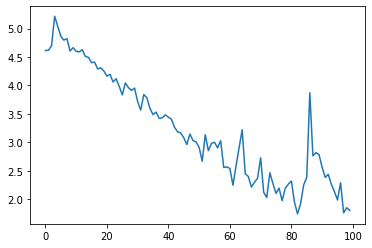

In [14]:
import matplotlib.pyplot as plt

plt.plot(dis_loss)


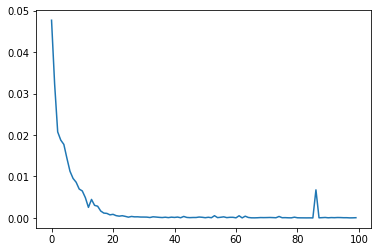

In [15]:
plt.plot(gan_loss)

In [0]:
y_train[0]

In [0]:
import numpy as np
fake = np.ones((128, NB_classes))  # fake is 0000

In [0]:
y